# Experiment

Dataset: GeoLife dataset discretized on 100 clusters and 30 minute interval.

## Requirements

- Pre-processed dataset located at `{ROOT}/data/geolife-c100`
- Pre-computed 100 clusters located at `{ROOT}/data/exploratory_analysis/geolife_mog_100.npy`

## Import and constants

In [1]:
import pandas as pd
import numpy as np
import math
import tqdm
import matplotlib.pyplot as plt
import os
import datetime
import random
import folium

## define dataset

### define path

Change the path variable here if you place your dataset files in a different location.

In [2]:
from src.path import ROOT

dataset_path = str(ROOT.joinpath('data/geolife-c100'))
cluster_path = f'{ROOT}/exploratory_analysis/geolife_mog_100.npy'

### get week with most persistent users

Get consecutive 7-day sequence with most no. of persistent users. We find that the no. of sequences starting from Thu to Wed is the highest.

In [4]:
from src.utils import set_intersect
from collections import deque

sets: deque[set[str]] = deque()

fnames = os.listdir(dataset_path)

def get_date(fname: str) -> datetime.date:
    fname = fname[:fname.index('.')]
    year, month, day = fname.split('-')
    return (int(year), int(month), int(day))

def get_uids(fname: str) -> set[str]:
    df = pd.read_csv(fname, dtype={ 'uid': str, 't': int, 'lat': np.float64, 'long': np.float64 })
    return set(df['uid'].unique().tolist())

fnames = sorted(fnames, key=get_date)

max_week = -1
max_count = 0

for week in tqdm.trange(7):
    i = 0
    count = 0

    while i < len(fnames) and len(fnames) - i > 7:
        d = get_date(fnames[i])
        start_date = datetime.date(year=d[0], month=d[1], day=d[2])

        if start_date.weekday() != week:
            i += 1
            continue

        sets: list[set[str]] = [get_uids(f'{dataset_path}/{fnames[i]}')]

        prev_date = start_date
        should_cont = False

        for j in range(1, 7):
            d = get_date(fnames[i + j])
            curr_date = datetime.date(year=d[0], month=d[1], day=d[2])

            if (curr_date - prev_date).days > 1:
                i += j
                should_cont = True
                break

            sets.append(get_uids(f'{dataset_path}/{fnames[i + j]}'))
            prev_date = curr_date

        if should_cont:
            continue

        i += 7
        count += len(set_intersect(*sets))

    if count > max_count:
        max_count = count
        max_week = week

print(max_week)
print(max_count)

100%|██████████| 7/7 [00:26<00:00,  3.75s/it]

4
4759


### load dataset

Load dataset files into in-memory and merge into single list.

In [6]:
from src.data_preprocess.trajectory import Trajectory, from_dataframe

SEQ_LENGTH = 48

test_trajectories: list[list[Trajectory]] = [[] for i in range(7)]

def read_csv(fname: str):
    # https://stackoverflow.com/questions/36909368/precision-lost-while-using-read-csv-in-pandas#:~:text=Pandas%20uses%20a%20dedicated%20decimal-to-binary%20converter%20that%20sacrifices,of%20speed.%20Passing%20float_precision%3D%27round_trip%27%20to%20read_csv%20fixes%20this.
    df = pd.read_csv(f'{dataset_path}/{fname}', float_precision='round_trip', dtype={ 'uid': str, 't': int, 'lat': np.float64, 'long': np.float64 })
    return from_dataframe(df, SEQ_LENGTH)

i = 0

while i < len(fnames) and len(fnames) - i > 7:
    d = get_date(fnames[i])
    start_date = datetime.date(year=d[0], month=d[1], day=d[2])

    if start_date.weekday() != max_week:
        i += 1
        continue

    should_cont = False
    prev_date = start_date


    for j in range(1, 7):
        d = get_date(fnames[i + j])
        curr_date = datetime.date(year=d[0], month=d[1], day=d[2])

        if (curr_date - prev_date).days > 1:
            i += j
            should_cont = True
            break

        prev_date = curr_date

    if should_cont:
        continue


    dfs = [read_csv(fname) for fname in fnames[i:i + 7]]

    sets = set_intersect(*[df.keys() for df in dfs])

    for j in range(7):
        for uid in sets:
            test_trajectories[j].append(dfs[j][uid])

    i += 7

assert all(len(test_trajectories[j]) == max_count for j in range(7))

#### Get contribution of each user

count the no. of trajectories contributed by each user

In [8]:
user_contribution: dict[str, int] = dict()

i = 0

while i < len(fnames) and len(fnames) - i > 7:
    d = get_date(fnames[i])
    start_date = datetime.date(year=d[0], month=d[1], day=d[2])

    if start_date.weekday() != max_week:
        i += 1
        continue

    should_cont = False
    prev_date = start_date


    for j in range(1, 7):
        d = get_date(fnames[i + j])
        curr_date = datetime.date(year=d[0], month=d[1], day=d[2])

        if (curr_date - prev_date).days > 1:
            i += j
            should_cont = True
            break

        prev_date = curr_date

    if should_cont:
        continue


    dfs = [read_csv(fname) for fname in fnames[i:i + 7]]

    sets = set_intersect(*[df.keys() for df in dfs])

    for j in range(7):
        for uid in sets:
            user_contribution[uid] = user_contribution.get(uid, 0) + 1

    i += 7

From the below plot, we have an imbalance of contribution. This maybe the reason of the higher accuracy we achieved in the merged set despite the higher no. of trajectories.

Note: Trajectory Recovery from Ash found that accuracy reduces as the no. of trajectories increases.

Text(0, 0.5, 'frequency')

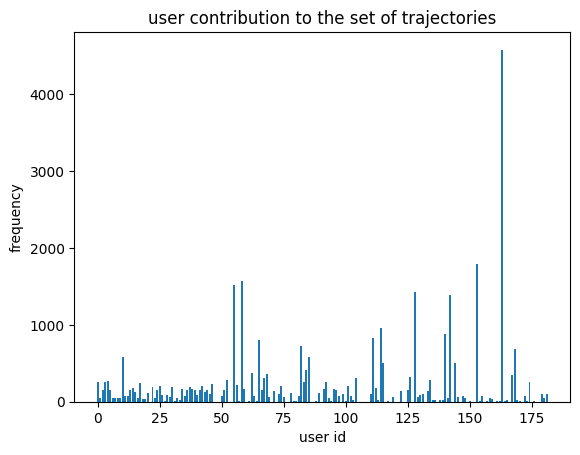

In [11]:
y = [0] * 182

for uid, count in user_contribution.items():
    y[int(uid)] = count

plt.bar([*range(182)], y)
plt.title('user contribution to the set of trajectories')
plt.xlabel('user id')
plt.ylabel('frequency')

### read basestations

In [5]:
all_candidates: np.ndarray = np.load(cluster_path)

## baseline

#### define metric

In [6]:
from src.main.baseline import RecoveryFromAshDistance

ref_lat = np.median(all_candidates[:, 0]).item()
ref_long = np.median(all_candidates[:, 1]).item()

day_timestamp = 12

distance_metric = RecoveryFromAshDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

#### night time trajectory recovery

In [7]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i]]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery: 100%|██████████| 7/7 [00:36<00:00,  5.15s/it]


Evaluate

In [8]:
from src.eval.metrics import greedy_match, similarity, mean_distance

avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 7/7 [00:14<00:00,  2.06s/it]

average accuracy: 0.9553702758682798
average recovery error: 0.28993054518294314


Visualize predicted trajectories

In [9]:
from src.plot import get_beijing_map, plot_trajectory

bucket_idx = random.randrange(len(test_trajectories))
trajectory_idx = random.randrange(len(test_trajectories[bucket_idx]))

target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[bucket_idx]]

indices = greedy_match(predicted[bucket_idx], target_trajectories)

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(target_trajectories[indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted[bucket_idx][trajectory_idx], color='blue', map=fg1)
map

#### single day trajectory recovery (night time + day time)

In [10]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i]]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 7/7 [02:25<00:00, 20.76s/it]


Evaluate

In [11]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 7/7 [00:53<00:00,  7.58s/it]

average accuracy: 0.9040958734828246
average recovery error: 0.6827534413728039


Visualize predicted trajectories

In [12]:
from src.plot import get_beijing_map, plot_trajectory

bucket_idx = random.randrange(len(test_trajectories))
trajectory_idx = random.randrange(len(test_trajectories[bucket_idx]))

indices = greedy_match(predicted[bucket_idx], test_trajectories[bucket_idx])

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(test_trajectories[bucket_idx][indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted[bucket_idx][trajectory_idx], color='blue', map=fg1)
map

### cross-day trajectory recovery

single day trajectory recovery

In [13]:
predicted: list[list[Trajectory]] = [None] * 7

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i]]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 7/7 [02:53<00:00, 24.84s/it]


cross-day recovery

In [14]:
from src.main.baseline import DenseCrossDayTrajectoryRecovery
from src.ml.dataset import create_point_to_class_map

point_to_index = create_point_to_class_map(all_candidates)

algorithm = DenseCrossDayTrajectoryRecovery(predicted, point_to_index, 100)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery:   0%|          | 0/6 [00:00<?, ?it/s]c:\users\chinp\source\neural-trajectory-model\src\main\baseline.py:333: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(np.log(counts) * counts, axis=-1)
c:\users\chinp\source\neural-trajectory-model\src\main\baseline.py:333: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(np.log(counts) * counts, axis=-1)
cross-day recovery: 100%|██████████| 6/6 [09:28<00:00, 94.72s/it] 


Evaluate

average accuracy: 0.8166350223636417
average recovery error: 1.3636140921069155


Text(0.5, 0, 'recovery error (km)')

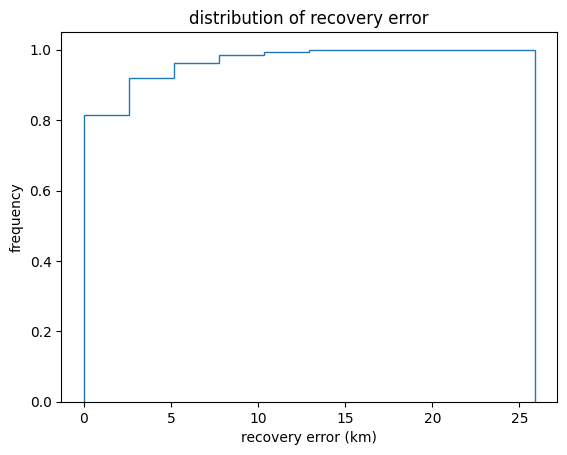

In [15]:
import copy
from src.eval.metrics import similarity, mean_distance

# merge target trajectories
target_trajectories = copy.deepcopy(test_trajectories[0])

for j in range(len(target_trajectories)):
    for i in range(1, len(test_trajectories)):
        target_trajectories[j].points += test_trajectories[i][j].points

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

[0.0004202563563773902, 0.09119562933389368, 0.17020382433284303, 0.20130279470476992, 0.20844715276318554]
[0.0016810254255095608, 0.0687119142677033, 0.19058625761714645, 0.29838201302794704, 0.34671149401134693]


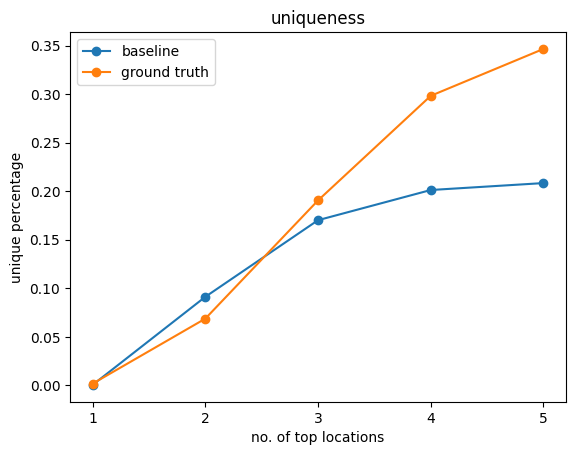

In [16]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted_trajectories, i + 1) for i in range(5)]
ground_truth_uniqueness = [ uniqueness_list(target_trajectories, k + 1) for k in range(5) ]
print(uniqueness)
print(ground_truth_uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o', label='baseline')
plt.plot([str(i + 1) for i in range(5)], ground_truth_uniqueness, marker='o', label='ground truth')
plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')
plt.legend()

Visualize predicted trajectories

In [17]:
from src.plot import get_beijing_map, plot_trajectory

trajectory_idx = random.randrange(len(target_trajectories))

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(target_trajectories[indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted_trajectories[trajectory_idx], color='blue', map=fg1)
map

## Baseline (no merge)

Since GeoLife is continuous after interpolation. Instead of entropy based cross-day merging, we can just repeat step-1 and step-2 to add points in the next day.

#### define metric

In [18]:
from src.main.baseline import RecoveryFromAshDistance

class MyDistance(RecoveryFromAshDistance):
    def compute(self, trajectories: np.ndarray, candidates: np.ndarray, tstamp: int) -> np.ndarray:
        '''
        compute cost matrix

        Args:
        ---
        - trajectories: [n1, L, (lat, long)]
        - candidates: [n2, (lat, long)]
        - tstamp: timestamp

        Returns:
        ---
        - cost matrix [n1, n2]
        '''
        if (tstamp % SEQ_LENGTH) < self.day_time:
            return self.night_time_distance(trajectories, candidates)
        else:
            return self.day_time_distance(trajectories, candidates)

ref_lat = np.median(all_candidates[:, 0]).item()
ref_long = np.median(all_candidates[:, 1]).item()

day_timestamp = 12

distance_metric = MyDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

### trajectory recovery

In [19]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations


algorithm = DailyTrajectoryRecovery(
    get_observations=lambda t: get_aggregated_observations(target_trajectories, t),
    cost_matrix=distance_metric.compute,
    sequence_length=len(target_trajectories[0]),
    sequence_count=len(trajectories)
)

algorithm.run(verbose=False)
predicted = algorithm.get_predicted_trajectories()

evaluate

average accuracy: 0.7958723571378541
average recovery error: 1.6071303552577834


Text(0.5, 0, 'recovery error (km)')

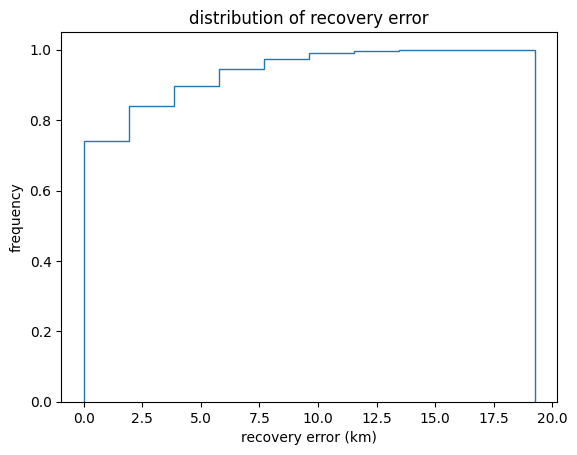

In [20]:
from src.eval.metrics import similarity, mean_distance

indices = greedy_match(predicted, target_trajectories)

accuracy = similarity(
    np.array(predicted),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

As expected, the merged dataset has low uniqueness.

[0.001891153603698256, 0.10317293549064929, 0.21391048539609162, 0.2525740701828115, 0.25971842824122715]


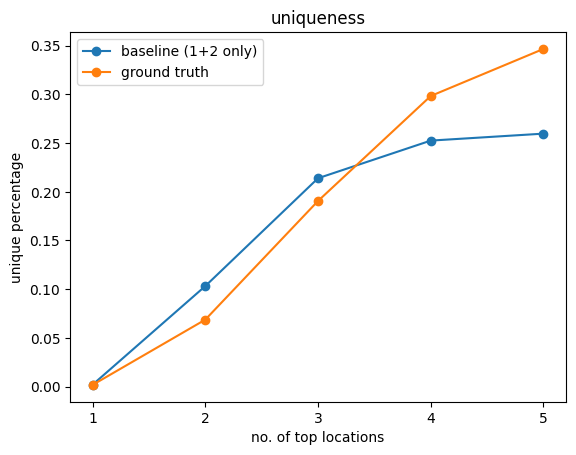

In [21]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted, i + 1) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o', label='baseline (1+2 only)')
plt.plot([str(i + 1) for i in range(5)], ground_truth_uniqueness, marker='o', label='ground truth')

plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')
plt.legend()

Surprisingly, performing step-3 can improve accuracy. Maybe step-3 prevents accumulation of error in step-1 and step-2?

Visualize predicted trajectories

In [22]:
from src.plot import get_beijing_map, plot_trajectory

trajectory_idx = random.randrange(len(target_trajectories))

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(target_trajectories[indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted[trajectory_idx], color='blue', map=fg1)
map